# GTZAN - Deep Learning

`Music Genre Classification Problem`. Experts have been trying for a long time to understand sound & what differentiates one from another. How to visualize sound. What makes one tone different from another.

We are going to analyze the features extracted from the GTZAN dataset and build different type of ensemble models to see how better we can differentiate one genre from another.

Our Datasets contains 10 genres:-
- Blues
- Classical
- Country
- Disco
- Hiphop
- Jazz
- Metal
- Pop
- Reggae
- Rock


# Reading & Understanding Data
## Importing Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import random
import librosa, IPython
import librosa.display as lplt
seed = 12
np.random.seed(seed)

### Loading Dataset

In [5]:
df = pd.read_csv('/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv')
df.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.771563  ...   39.687145   
1              2010.051501            65671.875673  ...   64.748276   
2              2084.565132            75124.921716  ...   67.336563   
3              1960.039988            82913.639269  ...   47.739452   
4              1948.503884            60204.020268  ...   30.336359   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -3.241280   36.488243     0.722209   38.099152    -5.050335   33.618073   
1    -6.055294   40.677654     0.159015   51.264091    -2.837699   97.030830   
2    -1.768610   28.348579     2.378768   45.717648    -1.938424   53.050835   
3    -3.841155   28.337118     1.218588   34.770935    -3.580352   50.836224   
4     0.664582   45.880913     1.689446   51.363583    -3.392489   26.738789   

   mfcc20_mean  mfcc20_var  label  
0    -0.243027   43.771767  blues  
1     5.784063   59.943081  blues  
2     2.517375   33.105122  blues  
3     3.630866   32.023678  blues  
4     0.536961   29.146694  blues  

[5 rows x 60 columns]

### About the dataset

In [6]:
print("Dataset has",df.shape)
print("Count of Positive and Negative samples")
df.label.value_counts().reset_index()

Dataset has (9990, 60)
Count of Positive and Negative samples


index  label
0     reggae   1000
1      blues   1000
2      metal   1000
3       jazz   1000
4        pop   1000
5      disco    999
6     hiphop    998
7       rock    998
8  classical    998
9    country    997

# Data Visualization

In [7]:
audio_fp = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00000.wav'
audio_data, sr = librosa.load(audio_fp)
audio_data, _ = librosa.effects.trim(audio_data)

In [8]:
# play sample file
IPython.display.Audio(audio_data, rate=sr)

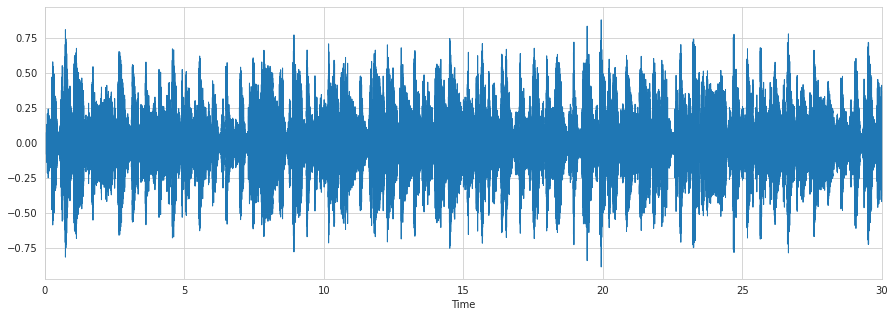

In [9]:
# plot sample file
plt.figure(figsize=(15,5))
lplt.waveplot(audio_data)
plt.show()

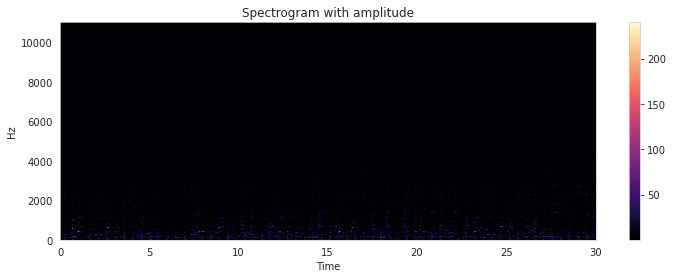

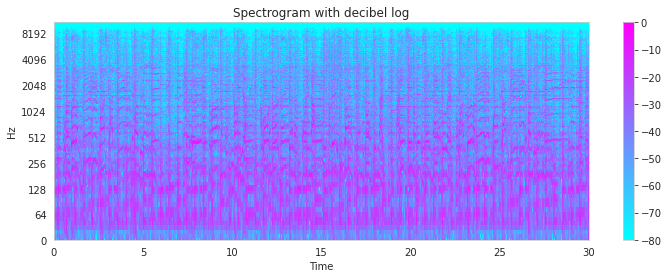

In [10]:
# Default FFT window size
n_fft = 2048 # window size
hop_length = 512 # window hop length for STFT

stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
stft_db = librosa.amplitude_to_db(stft, ref=np.max)

plt.figure(figsize=(12,4))
lplt.specshow(stft, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram with amplitude")
plt.show()

plt.figure(figsize=(12,4))
lplt.specshow(stft_db, sr=sr, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Spectrogram with decibel log")
plt.show()

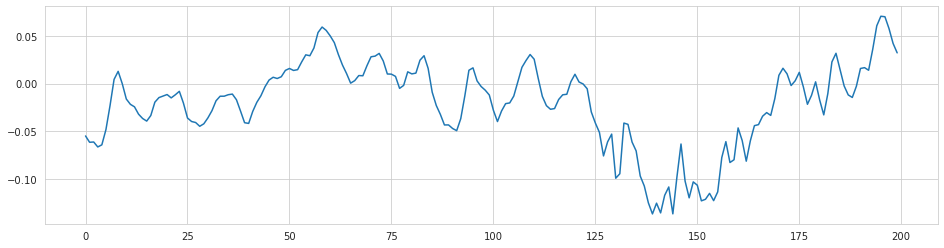

In [11]:
# plot zoomed audio wave 
start = 1000
end = 1200
plt.figure(figsize=(16,4))
plt.plot(audio_data[start:end])
plt.show()

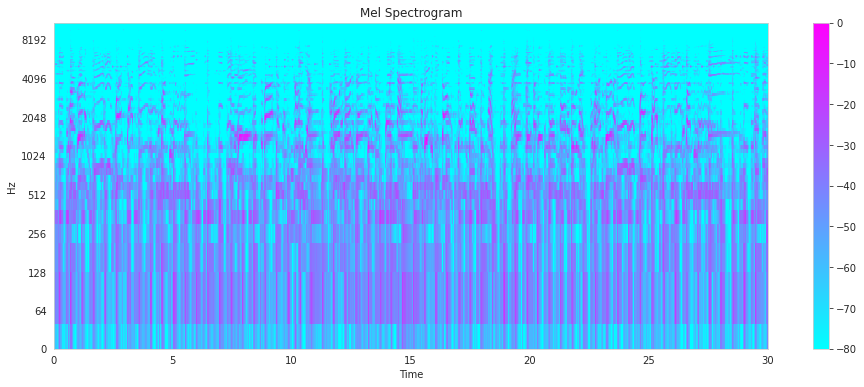

In [12]:
mel_spec = librosa.feature.melspectrogram(audio_data, sr=sr)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
plt.figure(figsize=(16,6))
lplt.specshow(mel_spec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Mel Spectrogram")
plt.show()

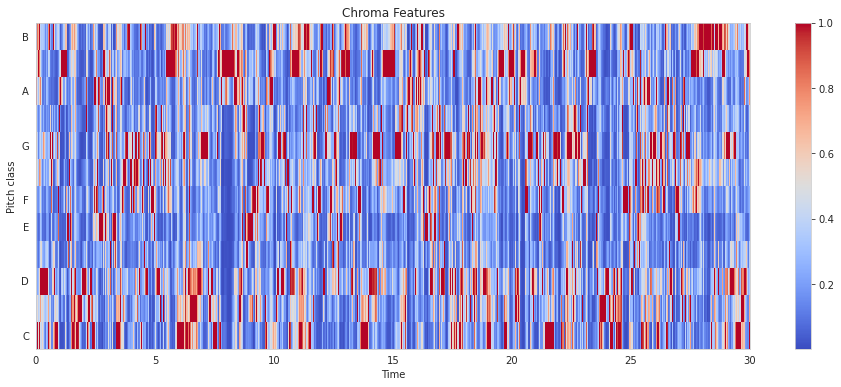

In [13]:
chroma = librosa.feature.chroma_stft(audio_data, sr=sr)
plt.figure(figsize=(16,6))
lplt.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title("Chroma Features")
plt.show()

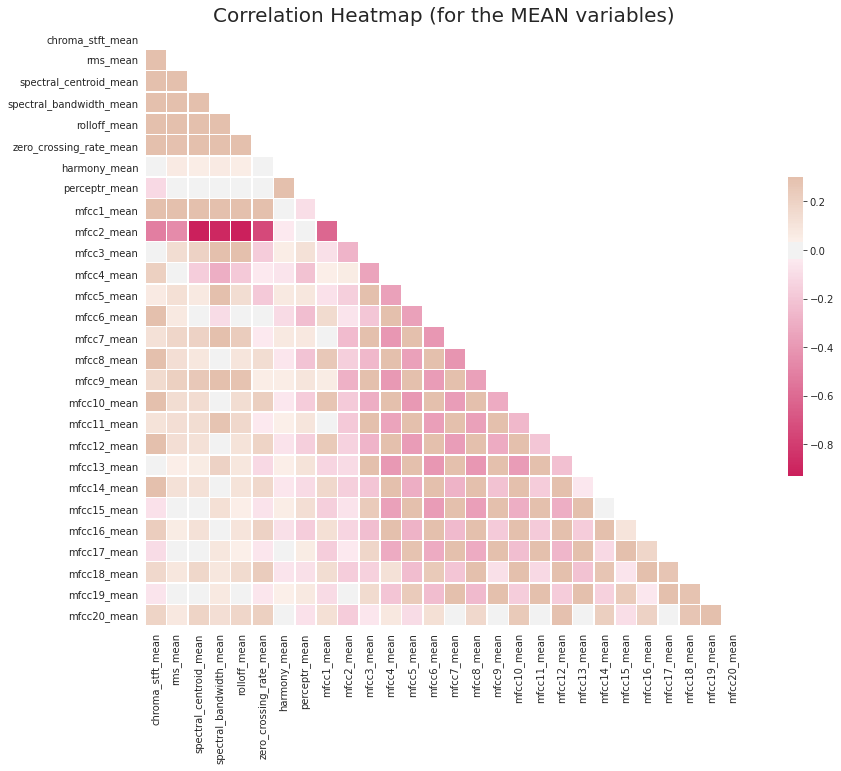

In [14]:
# Computing the Correlation Matrix
spike_cols = [col for col in df.columns if 'mean' in col]
corr = df[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("Corr_Heatmap.png")

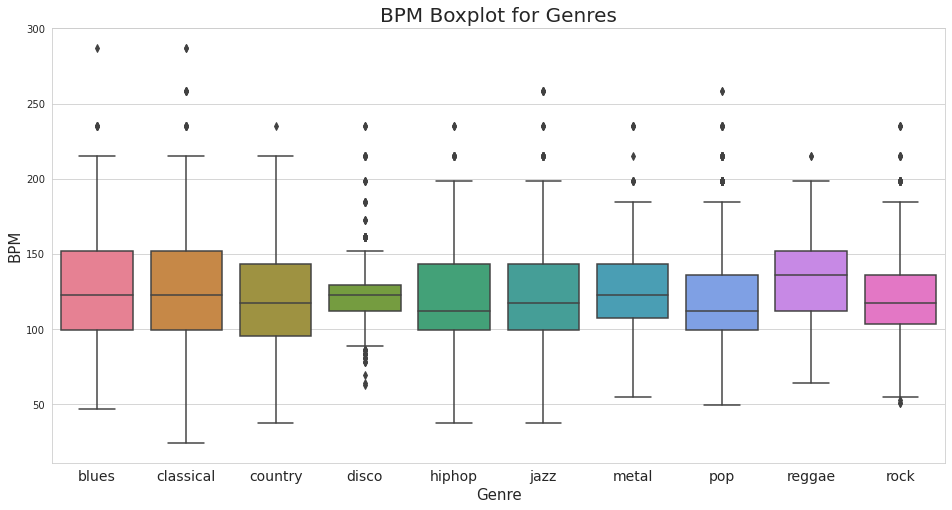

In [15]:
x = df[["label", "tempo"]]

fig, ax = plt.subplots(figsize=(16, 8));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM_Boxplot.png")

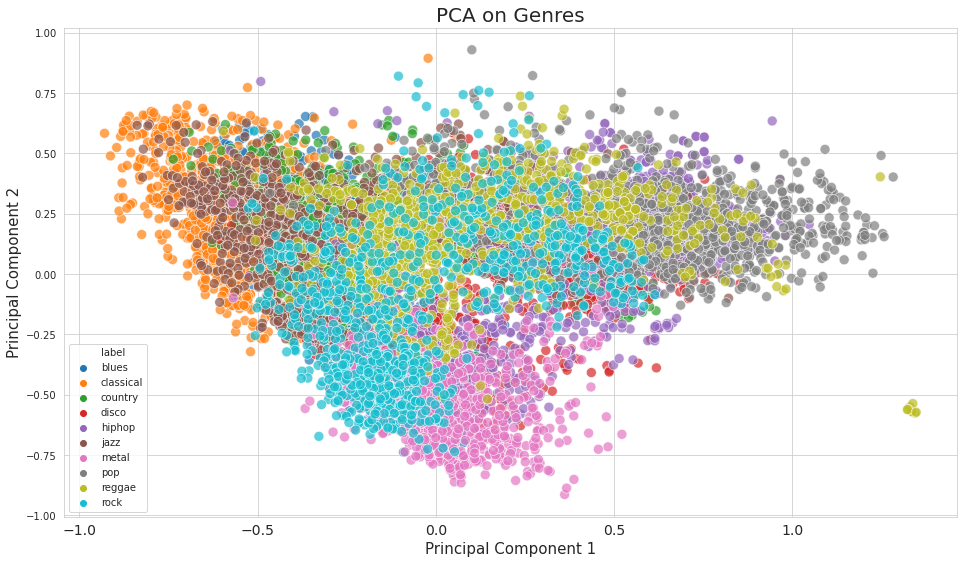

In [16]:
data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

# normalize
cols = X.columns
min_max_scaler = skp.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

# Top 2 pca components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

plt.figure(figsize = (16, 9))
sns.scatterplot(x = "pc1", y = "pc2", data = finalDf, hue = "label", alpha = 0.7, s = 100);

plt.title('PCA on Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA_Scattert.png")

# Data Preparation

- Treat missing values.
- Outlier Treatment
- Define dummy variables for categorical variables.

## Missing Value Treatment

In [17]:
# find all columns with any NA values
print("Columns with NA values are",list(df.columns[df.isnull().any()]))

Columns with NA values are []


`No null values in the dataset`



`There are no categorical variable as such. Hence, Dummy variable creation is not needed.`

## Encode Genre Label

In [18]:
# map labels to index
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


In [19]:
# update labels in df to index
df.label = [label_index[l] for l in df.label]

# Split Train, Dev & Test Sets

In [20]:
# shuffle samples
df_shuffle = df.sample(frac=1, random_state=seed).reset_index(drop=True)

In [21]:
# remove irrelevant columns
df_shuffle.drop(['filename', 'length'], axis=1, inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

# split into train dev and test
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)
X_dev, X_test, y_dev, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

In [22]:
print(f"Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Dev set has {X_dev.shape[0]} records out of {len(df_shuffle)} which is {round(X_dev.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")

Train set has 6993 records out of 9990 which is 70%
Dev set has 1978 records out of 9990 which is 20%
Test set has 1019 records out of 9990 which is 10%


In [23]:
print(y_train.value_counts()[0]/y_train.shape[0]*100)
print(y_dev.value_counts()[0]/y_dev.shape[0]*100)
print(y_test.value_counts()[0]/y_test.shape[0]*100)

10.01001001001001
10.010111223458038
10.009813542688912


## Scale the Features

In [24]:
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

# Model Building

In [25]:
import tensorflow as tf
print("TF version:-", tf.__version__)
import keras as k
tf.random.set_seed(seed)

TF version:- 2.3.1


In [26]:
ACCURACY_THRESHOLD = 0.94

class myCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print("\n\nStopping training as we have reached %2.2f%% accuracy!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

def trainModel(model, epochs, optimizer):
    batch_size = 128
    callback = myCallback()
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics='accuracy'
    )
    return model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=epochs, 
                     batch_size=batch_size, callbacks=[callback])

def plotHistory(history):
    print("Max. Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()


In [27]:
model_1 = k.models.Sequential([
    k.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dense(128, activation='relu'),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dense(10, activation='softmax'),
])
print(model_1.summary())
model_1_history = trainModel(model=model_1, epochs=70, optimizer='adam')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               14848     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 56,650
Trainable params: 56,650
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/70
55/55 [==============================] - 0s 6ms/step - loss: 1.4898 - accuracy: 0.4842 - val_loss: 1.0579 - val_accuracy: 0.6304
Epoch 2/70
55/55 [==============================] - 0s 3ms/step - loss: 0.8929 - accuracy: 0.7000 - val_l

Max. Validation Accuracy 0.8938321471214294


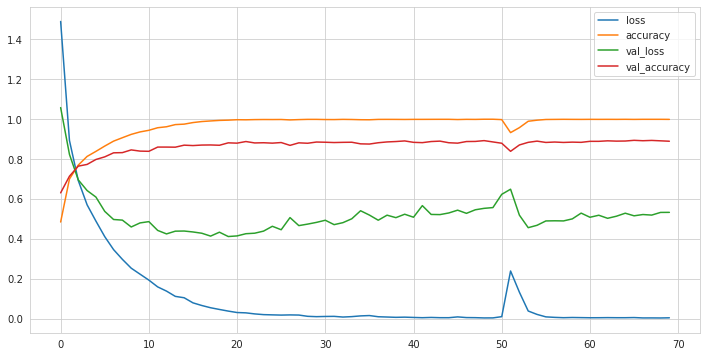

In [28]:
plotHistory(model_1_history)

In [29]:
model_2 = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),
    
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(10, activation='softmax'),
])
print(model_2.summary())
model_2_history = trainModel(model=model_2, epochs=100, optimizer='adam')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               29696     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)               

Max. Validation Accuracy 0.930738091468811


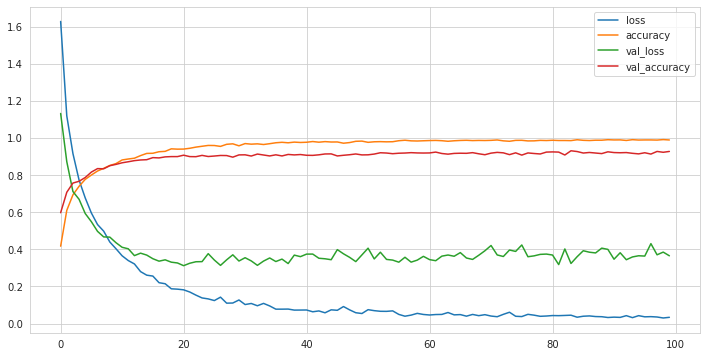

In [30]:
plotHistory(model_2_history)

In [31]:
model_3 = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),
    
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(10, activation='softmax'),
])
print(model_3.summary())
model_3_history = trainModel(model=model_3, epochs=700, optimizer='sgd')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               29696     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)               

Max. Validation Accuracy 0.9186046719551086


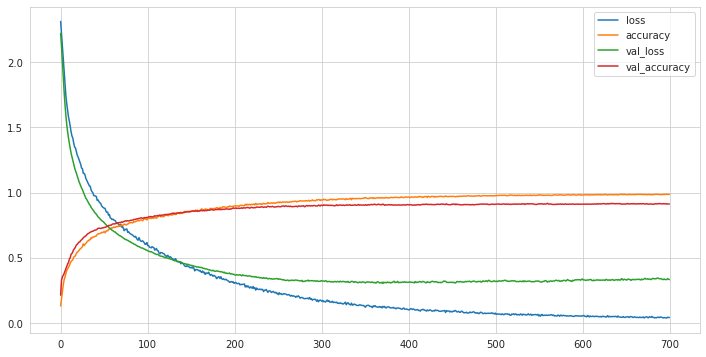

In [32]:
plotHistory(model_3_history)

In [33]:
model_4 = k.models.Sequential([
    k.layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.3),
    
    k.layers.Dense(512, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(10, activation='softmax'),
])
print(model_4.summary())
model_4_history = trainModel(model=model_4, epochs=500, optimizer='rmsprop')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 1024)              59392     
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)              

Max. Validation Accuracy 0.9383215308189392


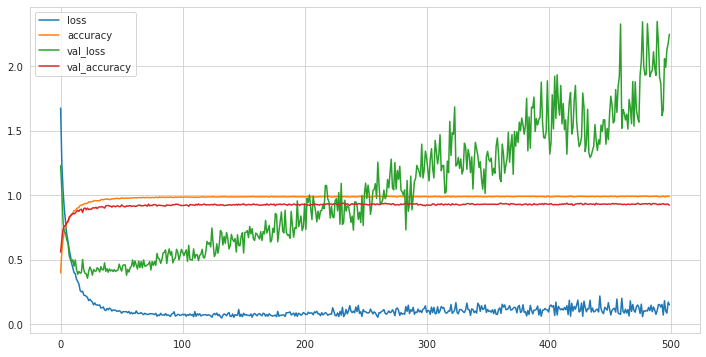

In [34]:
plotHistory(model_4_history)

# Model Evaluation

In [35]:
test_loss, test_acc  = model_4.evaluate(X_test, y_test, batch_size=128)
print("The test Loss is :",test_loss)
print("\nThe Best test Accuracy is :",test_acc*100)

8/8 [==============================] - 0s 4ms/step - loss: 1.8536 - accuracy: 0.9244
The test Loss is : 1.8536328077316284

The Best test Accuracy is : 92.44357347488403


In [36]:
# from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, f1_score
# from sklearn.model_selection import train_test_split
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.datasets import make_classification
# from sklearn.linear_model import LogisticRegression
# # Train a classifier (e.g., Logistic Regression)
# clf = LogisticRegression()
# clf.fit(X_train, y_train)

# y_scores = clf.predict(X_test)#[:, 1]
# # # Compute ROC curve and ROC area
# # fprate, tprate, thresholds = roc_curve(y_test, y_scores, pos_label=1)
# # # fpr, tpr, _ = roc_curve(y_test, y_scores)
# # roc_auc = auc(fpr, tpr)

# # Compute Precision-Recall curve and Precision-Recall area
# precision, recall, _ = precision_recall_curve(y_test, y_scores)
# pr_auc = average_precision_score(y_test, y_scores)

# # Compute F1-score
# f1 = f1_score(y_test, clf.predict(X_test))

# # Plot ROC curve
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC)')
# plt.legend(loc="lower right")
# plt.show()

# # Plot Precision-Recall curve
# plt.figure()
# plt.step(recall, precision, color='b', alpha=0.2, where='post')
# plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('Precision-Recall curve: AP={0:0.2f}'.format(pr_auc))
# plt.show()

# # Print F1-score
# print("F1-score:", f1)

In [37]:
# test_acc  = model_4.evaluate(X_test, y_test, batch_size=128)
# print("\nThe Best test Accuracy is :",test_acc*100)
# sum=sum+test_acc

8/8 [==============================] - 0s 3ms/step - loss: 1.8536 - accuracy: 0.9244

The Best test Accuracy is : [1.8536328077316284, 0.9244357347488403, 1.8536328077316284, 0.9244357347488403, 1.8536328077316284, 0.9244357347488403, 1.8536328077316284, 0.9244357347488403, 1.8536328077316284, 0.9244357347488403, 1.8536328077316284, 0.9244357347488403, 1.8536328077316284, 0.9244357347488403, 1.8536328077316284, 0.9244357347488403, 1.8536328077316284, 0.9244357347488403, 1.8536328077316284, 0.9244357347488403, 1.8536328077316284, 0.9244357347488403, 1.8536328077316284, 0.9244357347488403, 1.8536328077316284, 0.9244357347488403, 1.8536328077316284, 0.9244357347488403, 1.8536328077316284, 0.9244357347488403, 1.8536328077316284, 0.9244357347488403, 1.8536328077316284, 0.9244357347488403, 1.8536328077316284, 0.9244357347488403, 1.8536328077316284, 0.9244357347488403, 1.8536328077316284, 0.9244357347488403, 1.8536328077316284, 0.9244357347488403, 1.8536328077316284, 0.9244357347488403, 1.853

TypeError: unsupported operand type(s) for +: 'builtin_function_or_method' and 'list'